Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Phase 2 Project

### Importing Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#### Formatting Cell

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed

In [3]:
df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Column Names and descriptions for Kings County Data Set
(source: Data/column_names.md)
* **id** - unique identified for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  of Bedrooms/House
* **bathrooms** -  of bathrooms/bedrooms
* **sqft_livings** -  footage of the home
* **sqft_lots** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Data Cleaning

### Dropping Uncessary Columns

In [4]:
#df = df.drop(df[['id', 'date', 'view', 'lat', 'long', 'yr_renovated', 'sqft_living15', 'sqft_lot15']], axis=1)
#df.head()

In [5]:
#seeing what the model looks like if I leave in sqft_living15 and sqft_lot15
df = df.drop(df[['id', 'date', 'view', 'lat', 'long', 'yr_renovated']], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,1800,7503


### Checking Data Types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     19221 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.5+ MB


#### Removing the ? in sqft_basement

In [7]:
basement_size = df['sqft_basement'].value_counts()
basement_size

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
200.0       105
750.0       104
480.0       103
530.0       103
450.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
860.0        79
670.0        78
1100.0       78
780.0        76
550.0        76
650.0        75
240.0        74
680.0        73
380.0        73
360.0        72
850.0        72
940.0        71
770.0        71
910.0        71
440.0        69
290.0        69
1200.0       69
880.0        69
520.0        68
350.0        68
920.0        66
630.0        66
960.0        65
730.0        65
740.0        64
430.0        64
760.0        63
640.0        63
1010.0       63
280.0        62
820.0        62
570.0        62
340.0        62
560.0        62
950.0        62
460.0        61
790.0        61
310.0        58
1060.0       58
980.0        57
830.0        56
540.0        55
1040.0  

In [8]:
unknown_basements = df[df['sqft_basement'] == '?']
known_basements = df[df['sqft_basement'] != '?']

print(len(unknown_basements))
print(len(known_basements))

454
21143


In [9]:
sqft_basement = unknown_basements.apply(lambda x: x['sqft_living'] - x['sqft_above'], axis=1)
unknown_basements['sqft_basement'] = sqft_basement
unknown_basements.head()

<ipython-input-9-1aa7a46566a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_basements['sqft_basement'] = sqft_basement


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
6,257500.0,3,2.25,1715,6819,2.0,0.0,3,7,1715,0,1995,98003,2238,6819
18,189000.0,2,1.00,1200,9850,1.0,0.0,4,7,1200,0,1921,98002,1060,5095
42,861990.0,5,2.75,3595,5639,2.0,0.0,3,9,3595,0,2014,98053,3625,5639
79,720000.0,4,2.50,3450,39683,2.0,0.0,3,10,3450,0,2002,98010,3350,39750
112,272500.0,3,1.75,1540,12600,1.0,0.0,4,7,1160,380,1980,98038,1540,11656


In [10]:
cleaned_df = known_basements.append(unknown_basements)
cleaned_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,1800,7503


In [11]:
#changing to float so that decminals are in the same format
cleaned_df['sqft_basement'] = cleaned_df['sqft_basement'].astype(float)
cleaned_df['sqft_above'] = cleaned_df['sqft_above'].astype(float)

In [12]:
cleaned_df['sqft_basement'].value_counts().head()

0.0      13110
600.0      221
700.0      218
500.0      214
800.0      206
Name: sqft_basement, dtype: int64

#### Changing Zip Code to Category

In [13]:
print(len(df['zipcode'].value_counts()))

70


In [14]:
cleaned_df['zipcode'] = df['zipcode'].astype(str)

In [15]:
cleaned_df['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

### Dropping Bedroom Outliers

In [16]:
cleaned_df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [17]:
#dropping outliers
cleaned_df = cleaned_df.sort_values('bedrooms', ascending=False).reset_index()
cleaned_df = cleaned_df.drop([0,1,2])
cleaned_df.head(5)

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,19239,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745
4,13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2008,98004,2730,10400
5,8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1996,98144,1448,3866
6,18428,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,1918,98105,2460,4400
7,4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1908,98102,1960,2450


In [19]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          21594 non-null  int64  
 1   price          21594 non-null  float64
 2   bedrooms       21594 non-null  int64  
 3   bathrooms      21594 non-null  float64
 4   sqft_living    21594 non-null  int64  
 5   sqft_lot       21594 non-null  int64  
 6   floors         21594 non-null  float64
 7   waterfront     19218 non-null  float64
 8   condition      21594 non-null  int64  
 9   grade          21594 non-null  int64  
 10  sqft_above     21594 non-null  float64
 11  sqft_basement  21594 non-null  float64
 12  yr_built       21594 non-null  int64  
 13  zipcode        21594 non-null  object 
 14  sqft_living15  21594 non-null  int64  
 15  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(9), object(1)
memory usage: 2.8+ MB


### Exploring Data with Scatter Plot

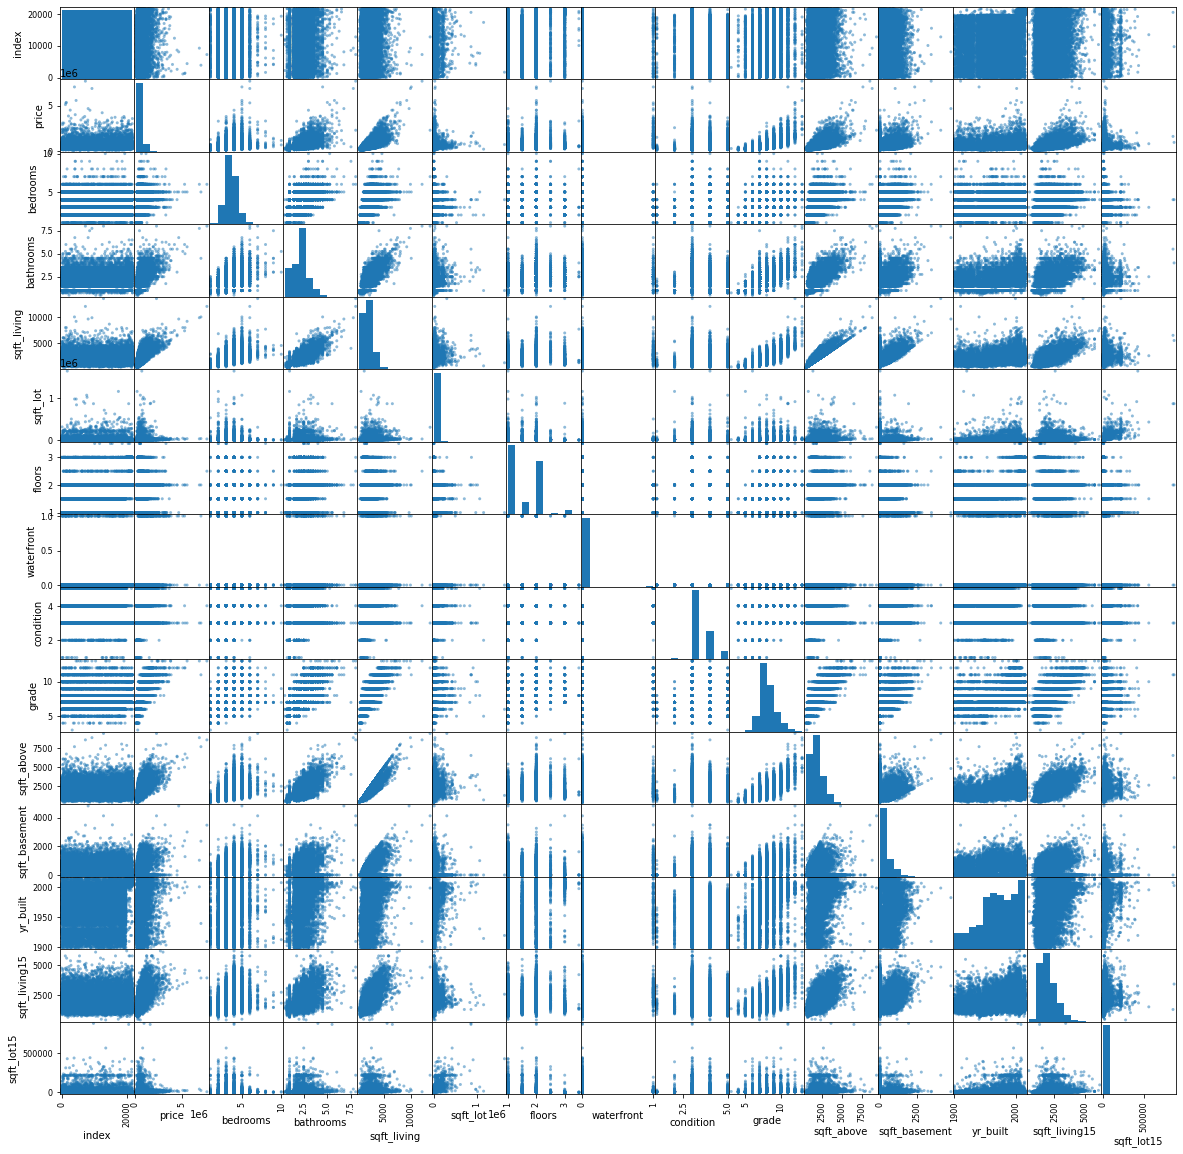

In [20]:
#using scatter plot to look for linear relationships
pd.plotting.scatter_matrix(cleaned_df, figsize = [20,20]);
plt.show()

### Analysis:
At first glance, the following variables seem to have linear relationships:
- price with bedrooms, sqft_above, & sqft_basement.
    - price also seems to have a linear relationship with categorical variable 'grade'.
- bedrooms with bathrooms, sqft_living, sqft_above, & sqft_basement
- sqft_living and sqft_above have the closest linear relationship
    - They are very similar data points. I may need to eliminate one to prevent multicolinearity.
    
The Following Variables seem to be categorical:
- floors
- waterfront
- condition
- zip code (not shown because I have already made it an object)

Ordinal Variables:
- bedrooms
- bathrooms



### What To Do with the Ordinal Values

I am going to treat grade as a continuous variable as it has very linear relationships with many features. Including price.

## Checking for Null Values

In [21]:
cleaned_df.isna().sum()

index               0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [22]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          21594 non-null  int64  
 1   price          21594 non-null  float64
 2   bedrooms       21594 non-null  int64  
 3   bathrooms      21594 non-null  float64
 4   sqft_living    21594 non-null  int64  
 5   sqft_lot       21594 non-null  int64  
 6   floors         21594 non-null  float64
 7   waterfront     19218 non-null  float64
 8   condition      21594 non-null  int64  
 9   grade          21594 non-null  int64  
 10  sqft_above     21594 non-null  float64
 11  sqft_basement  21594 non-null  float64
 12  yr_built       21594 non-null  int64  
 13  zipcode        21594 non-null  object 
 14  sqft_living15  21594 non-null  int64  
 15  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(9), object(1)
memory usage: 2.8+ MB


## Fixing Waterfront

In [23]:
cleaned_df['waterfront'].value_counts()

0.0    19072
1.0      146
Name: waterfront, dtype: int64

In [24]:
waterfront_cleaned = cleaned_df['waterfront'].fillna(0) 

In [25]:
cleaned_df['waterfront'] = waterfront_cleaned

In [26]:
cleaned_df['waterfront'].value_counts()

0.0    21448
1.0      146
Name: waterfront, dtype: int64

In [27]:
cleaned_df.isna().sum()

index            0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Building Condition

Should I change the condition values from numbers to words?

## Bedrooms

Should I change bedrooms so that there are less options? ie, <1 instead of 0, 0.5, etc

## One Hot Encoding

In [44]:
feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
cleaned_df[feats] = cleaned_df[feats].astype(str)
encoded_df = pd.get_dummies(cleaned_df, drop_first=True)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 99 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           21594 non-null  int64  
 1   price           21594 non-null  float64
 2   bathrooms       21594 non-null  float64
 3   sqft_living     21594 non-null  int64  
 4   sqft_lot        21594 non-null  int64  
 5   grade           21594 non-null  int64  
 6   sqft_above      21594 non-null  float64
 7   sqft_basement   21594 non-null  float64
 8   yr_built        21594 non-null  int64  
 9   sqft_living15   21594 non-null  int64  
 10  sqft_lot15      21594 non-null  int64  
 11  bedrooms_10     21594 non-null  uint8  
 12  bedrooms_2      21594 non-null  uint8  
 13  bedrooms_3      21594 non-null  uint8  
 14  bedrooms_4      21594 non-null  uint8  
 15  bedrooms_5      21594 non-null  uint8  
 16  bedrooms_6      21594 non-null  uint8  
 17  bedrooms_7      21594 non-null 

# Baseline Model
- running a model with the cleaned data.

In [45]:
test_df = encoded_df
test_df.head()

,index,price,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,sqft_living15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,19239,660000.0,3.00,2920,3745,7,1860.0,1060.0,1913,1810,...,0,0,0,0,0,0,0,0,0,0
4,13301,1150000.0,5.25,4590,10920,9,2500.0,2090.0,2008,2730,...,0,0,0,0,0,0,0,0,0,0
5,8537,450000.0,7.50,4050,6504,7,4050.0,0.0,1996,1448,...,0,0,0,0,0,0,0,0,0,0
6,18428,934000.0,3.00,2820,4480,7,1880.0,940.0,1918,2460,...,0,0,0,0,0,0,0,0,0,0
7,4231,700000.0,3.00,3680,4400,7,2830.0,850.0,1908,1960,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#df = df.reset_index()
#df = df.rename(columns={"index":"new_id"})
#df

In [47]:
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     884.7
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        13:18:07   Log-Likelihood:            -2.8999e+05
No. Observations:               21594   AIC:                         5.802e+05
Df Residuals:                   21496   BIC:                         5.810e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.387e+06   1.34e+05     10.314      0.000    1.12e+06    1.65e+06
index              0.1059      0.187      0.567      0.571      -0.260       0.472
bathrooms       2.926e+04   2706.580     10.811      0.000     2.4e+04    3.46e+04
sqft_living      117.3039      1.899     61.765      0.000     113.581     121.026
sqft_lot           0.2645      0.039      6.706      0.000       0.187       0.342
grade           6.379e+04   1878.260     33.965      0.000    6.01e+04    6.75e+04
sqft_above        90.7393      1.971     46.026      0.000      86.875      94.604
sqft_basement     26.5641      2.233     11.894      0.000      22.186      30.942
yr_built       -1016.0827     68.283    -14.880      0.000   -1149.923    -882.242
sqft_living15     27.9392      2.933      9.526      0.000      22.190      33.688
sqft_lot15        -0.1675      0.062     -2.700      0.007      -0.289      -0.046
bedrooms_10    -5.092e+05   1.18e+05     -4.332      0.000    -7.4e+05   -2.79e+05
bedrooms_2     -4.326e+04   1.23e+04     -3.525      0.000   -6.73e+04   -1.92e+04
bedrooms_3     -7.852e+04   1.21e+04     -6.468      0.000   -1.02e+05   -5.47e+04
bedrooms_4      -1.21e+05   1.24e+04     -9.760      0.000   -1.45e+05   -9.67e+04
bedrooms_5     -1.342e+05   1.31e+04    -10.218      0.000    -1.6e+05   -1.08e+05
bedrooms_6     -1.494e+05   1.62e+04     -9.233      0.000   -1.81e+05   -1.18e+05
bedrooms_7     -2.589e+05   2.99e+04     -8.653      0.000   -3.18e+05      -2e+05
bedrooms_8     -1.473e+05   4.79e+04     -3.073      0.002   -2.41e+05   -5.34e+04
bedrooms_9     -3.944e+05   6.91e+04     -5.706      0.000    -5.3e+05   -2.59e+05
floors_1.5     -2.442e+04   4566.607     -5.348      0.000   -3.34e+04   -1.55e+04
floors_2.0     -5.141e+04   3794.653    -13.548      0.000   -5.88e+04    -4.4e+04
floors_2.5      4.492e+04   1.37e+04      3.268      0.001     1.8e+04    7.19e+04
floors_3.0     -6.918e+04   8446.901     -8.190      0.000   -8.57e+04   -5.26e+04
floors_3.5       2.41e+04   6.29e+04      0.383      0.702   -9.93e+04    1.47e+05
waterfront_1.0  8.506e+05   1.41e+04     60.119      0.000    8.23e+05    8.78e+05
condition_2     5.864e+04   3.32e+04      1.764      0.078   -6521.143    1.24e+05
condition_3     5.165e+04   3.09e+04      1.673      0.094   -8873.193    1.12e+05
condition_4     6.901e+04   3.09e+04      2.234      0.026    8453.275     1.3e+05
condition_5     1.087e+05   3.11e+04      3.495      0.000    4.77e+04     1.7e+05
zipcode_98002   3.044e+04   1.46e+04      2.084      0.037    1811.611    5.91e+04
zipcode_98003  -1.517e+04   1.31e+04     -1.154      0.249   -4.09e+04    1.06e+04
zipcode_98004   7.593e+05   1.29e+04     58.797      0.000    7.34e+05    7.85e+05
zipcode_98005   2.721e+05   1.56e+04     17.487      0.000    2.42e+05    3.03e+05
zipcode_9800

## Test Normalization

In [ ]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [ ]:
data= test_df
data.head()

In [ ]:
data.info()

In [ ]:
data = data.drop('zipcode', axis=1)

In [ ]:
df_norm = norm_feat(data)
df_norm.head()

## Test Model with Test Normalized Data

In [ ]:
X = df_norm.drop('price', axis=1)
y = df_norm['price']

In [ ]:
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

# Data Exploration

## Building Condition Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.


In [ ]:
cleaned_df['condition'].value_counts()

## Building Grade Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)


Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

## Should I Drop Low Grade Houses?

In [ ]:
cleaned_df['grade'].value_counts()

I am only concerned with houses that currently meet the building code, so I will drop the houses which are grade 5 or lower

In [ ]:
low_grade = cleaned_df[cleaned_df['grade'] <= 5]
low_grade.head()

In [ ]:
low_grade['condition'].value_counts()

In [ ]:
low_grade['waterfront'].value_counts()

## Checking for Multicolinearity

In [ ]:
cleaned_df.head(1)

In [ ]:
#numeric variables
numeric_vars= ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
numeric_vars

In [ ]:
king_preprocessed = cleaned_df.loc[:,numeric_vars]
king_preprocessed.head()

In [ ]:
#scatter matrix for numeric variables
pd.plotting.scatter_matrix(king_preprocessed, figsize=[20, 20]);

In [ ]:
#correlation matrix
king_preprocessed.corr()

In [ ]:
abs(king_preprocessed.corr()) > 0.75

In [ ]:
cc_df = king_preprocessed.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

I need to remove some of these variables to prevent multicolineartiy. 


### Multicollinearity Analysis

There are 4 sets of variables that are highly correlated.  

In [ ]:
#removing these two variables removes all of the colinearity pairs
#king_preprocessed.drop(columns=['sqft_above', 'sqft_living'], inplace=True)

In [ ]:
king_preprocessed.drop(columns=['sqft_above'], inplace=True)

In [ ]:
#checking for correlated pairs again
cc_df = king_preprocessed.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

In [ ]:
king_preprocessed

## Check VIF Scores!!!!

## Normalizing Data

In [ ]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [ ]:
data = norm_feat(king_preprocessed)
data

In [ ]:
df_norm = norm_feat(data)
df_norm

In [ ]:
sns.pairplot(df_norm)

In [ ]:
#sns.heatmap(df_norm);

In [ ]:
#data_pred = df_norm

## Plotting Categoricals and then One-Hot Encoding them

## Dealing with Zip Code
I Need to get Zipcode back in the dataframe so that I can encode it.
Maybe I should do the One Hot Encoding much earlier in my workflow.

In [ ]:
#categoricals = df_norm[['bedrooms', 'bathrooms', 'floors','condition', 'waterfront', 'grade']]

In [ ]:
#categoricals = df_norm[['floors','waterfront', 'grade']]

In [ ]:
#categoricals.head()

In [ ]:
#king_preprocessed

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10), sharey=True)

for col, ax in zip(categoricals, axes.flatten()):
    (king_preprocessed.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()


In [ ]:
#sns.heatmap(categoricals)

In [ ]:
#correlation matrix. 
#df.corr()

In [ ]:
#df_pred_222 = abs(df.corr() > 0.75)

### One Hot Encoding

In [ ]:
feats = ['floors', 'waterfront', 'condition']
feats_df = king_preprocessed[feats].astype(str)
encoded_df = pd.get_dummies(feats_df, drop_first=True)
encoded_df.head()

In [ ]:
df = pd.get_dummies(feats_df, drop_first=True)
df

In [ ]:
df

In [ ]:
pd.get_dummies(feats_df, )

In [ ]:
pd.get_dummies(king_preprocessed.grade)

In [ ]:
#trying sklearn method
ohe = OneHotEncoder(drop='first')

In [ ]:
king_preprocessed.head(1)

In [ ]:
data_trans = ohe.fit_transform(king_preprocessed)
data_trans.todense()

In [ ]:
data_trans = pd.DataFrame(data_trans.todense(), columns=ohe.get_feature_names())
data_trans.head()

# Modeling

# Archive

In [ ]:
#df['waterfront'].value_counts()

In [ ]:
#df['waterfront'] = df['waterfront'].astype('bool') #converting waterfront into boolean

## Resetting IDs to make them shorter

In [ ]:
X = test_df.drop('price', axis=1)
y = test_df['price']